In [20]:
%matplotlib inline

from IPython.core.display import HTML
HTML("""
<style> 
.output_result { 
    display: table-cell;
    text-align: center;
    vertical-align: middle;  
} 
</style>
""")

# Aplicación de algoritmos genéticos al diseño de filtros IIR en punto fijo 

## Extracto

El desempeño de los filtros digitales en general, y de los filtros de respuesta impulsional infinita o IIR en particular¹, se ve afectado por las representaciones numéricas finitas utilizadas para su implementación. Las herramientas de análisis y síntesis típicas², lineales, no intentan modelar los efectos que impone una aritmética con restricciones³. Ésto se torna particularmente notorio en representaciones de punto fijo de relativo bajo número de bits⁴ -valiosas por su sencillez, reducido costo y alta velocidad-, al punto de deformar completamente la respuesta del filtro proyectado.

Se vuelve necesario recurrir a otros métodos para arribar a una solución satisfactoria, maximizando una métrica cuantificable de ese grado de satisfacción, en ocasiones en detrimento de otros aspectos de la solución. Los algoritmos genéticos, una subclase dentro del conjunto de algoritmos evolutivos, llevan a cabo esta búsqueda mediante operaciones inspiradas en el proceso de selección natural. De carácter probabilístico, no garantizan la solución óptima pero permiten la exploración de universos de discurso extensos en un tiempo acotado.

¹ La realimentación combinada con operatorias de truncado y desborde puede resultar en oscilasciones sostenidas. 
² Como ser, la transformada Z y el mapeo bilineal en tándem con _frequency warping_ para extender soluciones en tiempo continuo a tiempo discreto, etc.
³ Producto de acumuladores finitos para albergar los resultados parciales de sumas y multiplicaciones, el redondeo, truncado y/o saturación necesarios para mantener el resultado en valores representables, etc.
⁴ Conforme el número de bits crece y se abandona el punto fijo por el punto flotante, la discrepancia entre representación continua y discreta se vuelve despreciable.

## Estudio preliminar

### Procesamiento digital de señales

#### Filtrado en tiempo discreto

Todo filtro puede ser descripto por su ecuación en diferencias:

$$
\begin{equation}
y[k] = \sum^N_{n = 0} b_n \cdot x[k - n] - \sum^M_{m = 1} a_m \cdot y[k - m]
\end{equation}
$$

Esta ecuación permite computar la respuesta muestra a muestra (respuesta temporal si se asume un período de muestreo $t_s$ dado) e indica la estructura más simple (directa) del filtro.

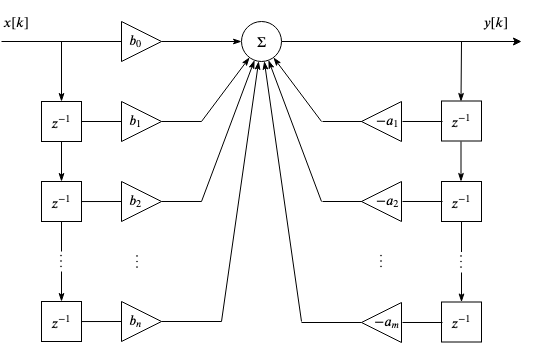

In [21]:
from IPython.display import Image
Image('diagrams/IIR.png')

Asumiendo coeficientes $b_n$ y $a_m$ invariantes en el tiempo, la transformada Z de la ecuación en diferencias resulta:

$$
\begin{equation}
\frac{Y(z)}{X(z)} = \frac{\sum^N_{n = 0} b_n \cdot z^{-n}}{1 + \sum^M_{m = 1} a_m \cdot z^{-m}} \\ 
z = re^{j\Omega}
\end{equation}
$$

Para $\|z\| = 1$, obtenemos la respuesta en frecuencia del filtro. 

Se observa que las raíces del polinomio numerador de coeficientes $b_n$ constituyen los ceros de esta función y las raíces del polinomio denominador de coeficientes $a_m$ constituyen los polos.

#### Efectos de la representación numérica

Los valores de entrada $x[k]$, de salida $y[k]$, y coeficientes $b_n$ y $a_m$ deben ser representados en forma binaria para su procesamiento. En lo que sigue, se asume una representación binaria signada en complemento a 2 de punto fijo de $N_e.N_f$ bits, que permite procesar magnitudes fraccionales utilizando unidades aritmético-lógicas para enteros signados:

$$ -2^{N_b-1} \leq x \leq 2^{N_b-1}-\frac{1}{2^{N_f}} $$

Coeficientes producto un diseño con mayor precisión numérica deben ser truncados o redondeados para ser representados de esta forma. El resultado parcial de cada multiplicación requiere $2(N_b + N_f)$ bits para su representación exacta, lo cual también implica, tarde o temprano, su truncado o redondeo. Las sucesivas sumas deben alojarse en un acumulador de $N_a$ bits, por lo que están sujetas a desborde o saturación. 

Cada una de estas operatorias no lineales reduce el rango dinámico efectivo de la representación y distorsiona el filtro predeterminado por otros medios.

### Algoritmo genético

En su forma más simple, un algoritmo de esta clase puede ser descripto por el siguiente diagrama de flujo:

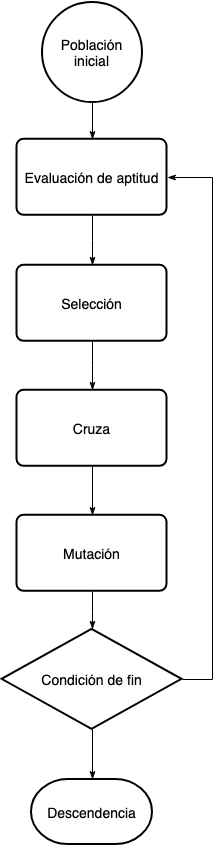

In [22]:
from IPython.display import Image
Image('diagrams/GA.png')

Una población inicial de individuos, en principio generada de forma aleatoria -pero bien puede ser el resultado
de conocimiento o procesos previos-, es seleccionada en función de la aptitud de su fenotipo (o conjunto de características observables) y luego sometida a operadores de cruza y mutación de su genotipo (o conjunto de genes que codifica dichas características) para generar descendencia. Esta operatoria se repite a lo largo de generaciones hasta que una condición de fin o término dada se cumple. Los genes que redundan en individuos más aptos tenderán, en promedio, a incrementar su frecuencia de ocurrencia.

También en su forma más simple, la implementación de este algoritmo codifica los genes en secuencias binarias y opera sobre subconjuntos de éstas. Como se verá más adelante, el desempeño de esta heurística inspirada en la biología es fuertemente dependiente de la representación del genotipo de los individuos, de la diversidad genética inicial, de la clausura (o su ausencia) de los operadores genéticos respecto al universo de discurso y de la tendencia de los mismos a preservar los genes más aptos a través de las generaciones, etc., al punto de exhibir severos problemas de convergencia si el delicado balance entre los factores involucrados se ve afectado.

## Aplicación

### Algoritmo

#### Genotipo (o representación)

Sin hipótesis simplificadora alguna, una representación compacta de un filtro digital requiere de todos sus coeficientes. 

Parte de las dificultades en la síntesis de filtros digitales en punto fijo radica en el hecho de que el procedimiento normalmente se efectúa en $\mathbb{R}$, en lugar del subconjunto $U \subset \mathbb{R}$ con aritmética modular en el que se lo implementa. Por ello, los coeficientes se representarán en $1.N_b$ desde un comienzo. 

La estructura del filtro digital también tiene consecuencias sobre su desempeño. La sensibilidad a los errores numéricos crece con el orden. Las sumas parciales pueden ocasionar el desborde o saturación de los acumuladores que las almacenan. La decomposición en secciones de segundo orden y su ordenamiento tal que se minimize la posibilidad de desborde o saturación es una solución tipica en implementaciones tradicionales a estos problemas.

Con estas consideraciones, el genotipo de cada filtro queda conformado por una secuencia de secciones de segundo orden $\{SOS_0, SOS_1, ..., SOS_i\}$, donde la ecuación en diferencias de la sección $SOS_i$ es:

$$
\begin{equation}
y_i[k] = c_0 \cdot \Bigl( b_0 \cdot x_i[k] + b_1 \cdot x_i[k-1] + b_2 \cdot x_i[k-2] - a_1 \cdot y_i[k-1] - a_2 \cdot y_i[k-2] \Bigr)
\end{equation}
$$

o simplemente $[b_0, b_1, b_2, a_1, a_2, c_0]$.

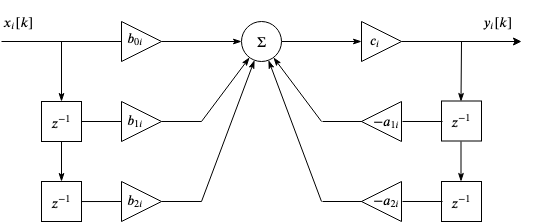

In [23]:
from IPython.display import Image
Image('diagrams/FWLIIR.png')

Notar que el término $a_0$ queda tácito, pues es siempre 1. Para lidiar con órdenes impares, una sección de primer orden puede introducirse haciendo $b_2 = a_2 = 0$. El agregado de una ganancia de etapa $c_0$ permite cambios de escala de los coeficientes a modo de mantenerlos en el intervalo de valores representables.

#### Operadores

##### Evaluación

La aptitud de cada filtro se evalúa en relación al desempeño deseado. En la síntesis tradicional, el filtro exhibe un respuesta al impulso o una respuesta en frecuencia dadas o con ciertas características a partir de la utilización de teoría de aproximación, muestreo, convolución con ventanas, etc. En este caso, de forma empírica se ha determinado que la métrica de aptitud que mejor resultados arroja es:

$$
f = \frac{1}{\mu_{er}^2 + \sigma_{er}^2}
$$

donde

$$
er[i] = \frac{h[i] - h_t[i]}{\underset{i}{max} \|h_t[i]\|}
$$

es el error relativo de la respuesta impulsional del filtro $h$ respecto a la respuesta impulsional de la plantilla $h_t$;

$$
\mu_{er} = \frac{1}{N} \sum^N_{i = 0} er[i]
$$

es la media de dicho error relativo $er$;

$$
\sigma^2_{er} = \frac{1}{N - 1} \sum^N_{i = 0} (er[i] - \mu_{er})^2
$$

es la varianza de dicho error relativo $er$. El valor apropiado de N dependerá de cada respuesta a aproximar.

Observar que el denominador de la función $f$ tiene es numéricamente equivalente a la potencia de $er$ en calidad de variable aleatoria.

##### Selección

Los operadores de selección mediante muestreo de la población adoptando la aptitud, o una estratificación construidad a partir de ella, como probabilidad de ocurrencia no ha mostrado buen desempeño. Frecuentemente, el algoritmo presentaba problemas de convergencia. 

El operador de torneo, o la selección determínistica del más apto en grupos conformados de forma aleatoria, ha mostrado mejores resultado y es la utilizada. Es, además, fácilmente ajustable: la presión de selección aumenta con el tamaño del torneo. Torneos grandes atentan contra la diversidad del pool genético y deben evitarse.

##### Cruza

El operador de cruza debe, en promedio, favorecer la reproducción de genes aptos. 

Los operadores de cruza binaria, como ser el de corte en uno o dos puntos aplicados sobre la secuencia completa de coeficientes, no ha mostrado buen desempeño, probablemente atribuible a la alta pero acotada variabilidad que introducen en el punto de corte (considerando el peso desigual de cada bit en una representación numérica binaria). 

La cruza uniforme de secciones de segundo orden, es decir el intercambio probable de a pares ordenados de secciones de los progenitores para dar origen a su descendencia, ha mostrado mejores resultados. Más aún, la cruza uniforme de numeradores y denominadores de la función transferencia de cada sección, tomadas de a pares aleatorios ha mostrado aún mejores resultados y es la utilizada. Se observa que este operador favorece la intercambio de polos y ceros y su redistribución.

##### Mutación

El operador de mutación debe introducir, en promedio, ligeras perturbaciones en los genes que eviten el estancamiento en máximos locales y contribuyan a la exploración del espacio de soluciones. 

Los operadores de mutación binaria, como ser la inversión de bits, no han mostrado buen desempeño, probablemente atribuible al peso desigual de cada bit en una representación numérica binaria y el consiguiente efecto en la magnitud de las perturbaciones. 

La adición de una perturbación como variable aleatoria de distribución normal a los coeficientes, entendidos como valores numéricos, ha motrado en cambio buenos resultados y es la utilizada.

#### Variaciones

##### Población inicial

La generación de la población inicial, si bien aleatoria, se limita a conformar filtros con secciones de segundo orden estables y de fase mínima (es decir, polos y ceros dentro o sobre la circunferencia unidad en el plano Z), asumiendo que la solución se hallará en la inmediaciones. Pese a que el algoritmo no intenta minimizar orden, filtros de distinta complejidad son gestados para luego seleccionar los más simples. 

##### Historial de más aptos

Los más individuos más aptos a lo largo de todas las generaciones son conservados, evitando perder buenas soluciones producto del caracter aleatorio del proceso evolutivo. 

##### Propagación elitista

Para mejorar la convergencia, el recambio generacional de la población se ha modificado, introduciendo una proporción de individuos de la población, los más aptos (o la elite), en su descendencia y seleccionando a los mejores del conjunto para la próxima generación. 

Esta proporción y el tamaño de los grupos de selección por torneo están fuertemente ligadas. Torneos grandes con una proporción de individuos de elite considerable provocan pérdida de diversidad y convergencia prematura.

##### Condición de término 

El algoritmo avanza la población a lo largo de un número fijo de generaciones.

#### Diagrama

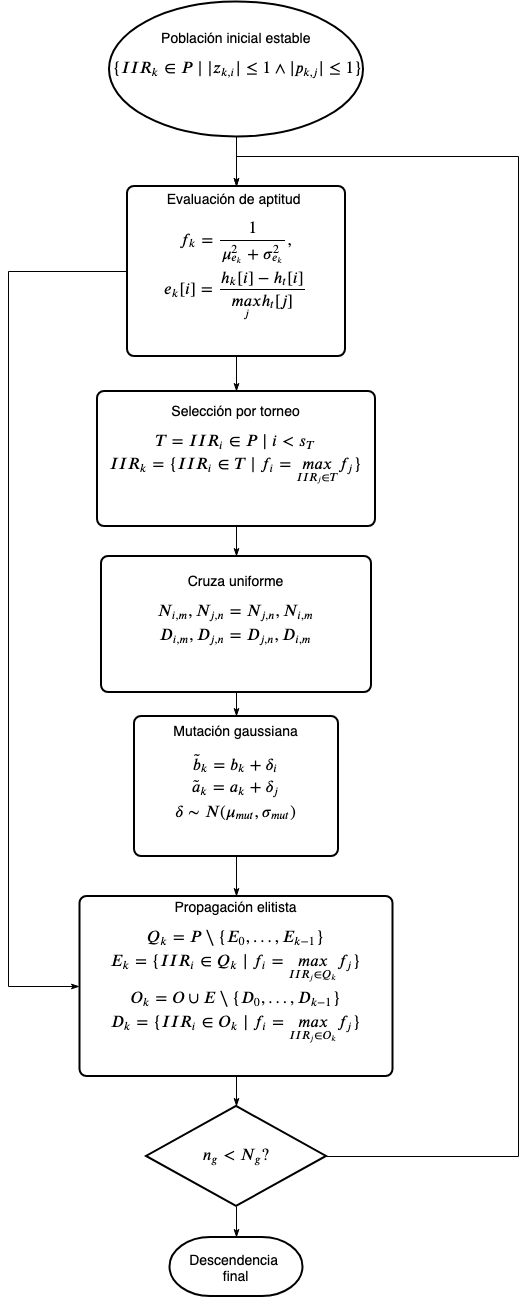

In [24]:
from IPython.display import Image
Image('diagrams/IIRGA.png')

### Implementación

El algoritmo se implementó como módulo en Python 3.6, utilizando los paquetes [numpy](https://www.numpy.org/), [scipy](https://scipy.org/) y [deap](https://deap.readthedocs.io/en/master/).

Se reproduce literalmente debajo:

```python
from deap import base
from deap import algorithms
from deap import tools
from deap import creator

import random
import functools
import numpy as np
import scipy.signal as signal

creator.create(
    'ResponseMismatch', base.Fitness, weights=(1.0,)
)
creator.create(
    'IIR', list, fitness=creator.ResponseMismatch, nbits=int
)
IIR = creator.IIR


def fitfwlsos(sos, nbits):
    """
    Ajusta la ganancia de una etapa de segundo orden en punto fijo
    para que sus coeficientes puedan representarse en 1.(`nbits`-1)

    :param sos: etapa de segundo orden de filtro digital IIR
       en punto fijo.
    :param nbits: cantidad de bits de la representación en
       punto fijo de los coeficientes de la etapa.
    """
    # Computa el límite númerico de la representación entera signada.
    n = 2**(nbits - 1)
    # Busca el coeficiente de máximo valor absoluto.
    c = sos[np.argmax(np.abs(sos[-1] * sos[:-1]))]
    if abs(c) >= n:
        # Escala todos los coeficientes para que el coeficiente
        # de máximo valor absoluto sea -1 en punto fijo.
        sos[:-1] = -n * sos[-1] * sos[:-1] // abs(c)
        # Conserva el factor de escala aplicado.
        sos[-1] = min(-1, -abs(c) // n)
    return sos


def fwliirimpulse(iir, ts, n):
    """
    Computa la respuesta al impulso de un filtro digital IIR
    en punto fijo.

    El filtro se representa como una secuencia ordenada de
    etapas de segundo orden, cada una representada por los
    coeficientes de su ecuación en diferencias más una
    ganancia: [b0, b1, b2, a1, a2, k]. El coeficiente a0 se
    asume unitario. Etapas de primer orden pueden obtenerse
    haciendo b2 = a2 = 0.

    :param iir: filtro digital IIR en punto fijo.
    :param ts: período de muestreo, en segundos.
    :param n: cantidad de muestras.
    :return: tiempo y respuesta al impulso, como tupla.
    """
    # Inicializa en cero los vectores de salida de
    # cada una de las M etapas del filtro más el de
    # entrada. Cada vector puede contener N muestras
    # más 2 muestras adicionales para conformar la
    # línea de demora.
    y = np.zeros([len(iir) + 1, n + 2], dtype=int)
    # Inicializar el vector de entrada con un delta
    # discreto.
    y[0, 2] = 2**(iir.nbits-1) - 1
    # Computar para cada instante discreto las salidas
    # de cada etapa, desde la primera hasta la última
    # en ese orden.
    for j in range(2, n + 2):
        for i, sos in enumerate(iir, start=1):
            b0, b1, b2, a1, a2, k = sos
            # Computar la ecuación de diferencias, truncando
            # y saturando el resultado para ser representado
            # en punto fijo 1.(`nbits`-1)
            y[i, j] = np.clip((k * (
                b0 * y[i - 1, j] +
                b1 * y[i - 1, j - 1] +
                b2 * y[i - 1, j - 2] -
                a1 * y[i, j - 1] -
                a2 * y[i, j - 2]
            )) >> (iir.nbits - 1), -2**(iir.nbits - 1), 2**(iir.nbits - 1) - 1)
    # Retorna respuesta al impulso renormalizando la salida
    # al intervalo [-1, 1)
    # salida del
    t = ts * np.arange(n)
    im = y[-1, 2:] / 2**(iir.nbits - 1)
    return t, im


def fwliir2sos(iir):
    """
    Convierte un filtro digital IIR en punto fijo a su representación
    como secuencia de secciones de segundo orden en punto flotante (ver
    `scipy.signal.sos2tf` como referencia).

    :param iir: filtro digital IIR en punto fijo.
    :return: filtro digital en representación SOS.
    """
    # Computa el límite númerico de la representación entera signada.
    n = 2**(iir.nbits - 1)
    # Escala el filtro digital en punto fijo acorde a la ganancia y
    # normaliza al intervalo [-1, 1) en punto flotante.
    return np.array([
        (*(sos[-1] * sos[:3] / n), 1.,
         *(sos[-1] * sos[3:5] / n))
        for sos in iir
    ])


def genStablePrototype(nlimit, nbits=32):
    """
    Genera un filtro digital IIR en punto fijo estable en
    forma aleatoria.

    :param nlimit: orden máximo admitido para el filtro.
    :param nbits: cantidad de bits utilizados para la
      representación numérica de los coeficientes.
    :return: filtro digital IIR en punto fijo generado.
    """
    iir = IIR()
    # Computa el límite númerico de la representación entera signada.
    n = 2 ** (nbits - 1)
    # Selecciona el orden del filtro en forma aleatoria
    # del intervalo [1, nlimit].
    order = max(int(random.random() * (nlimit + 1)), 1)
    # Si el orden es impar se introduce una etapa de primer orden.
    if order % 2 != 0:
        # Cero y polo de la etapa se ubican dentro o sobre el
        # círculo unidad.
        b0 = n
        b1 = np.random.randint(-n, n-1)
        a1 = np.random.randint(-n, n-1)
        sos = np.array([b0, b1, 0, a1, 0, 1])
        # Ajusta la ganancia de la sección para su representación.
        fitfwlsos(sos, nbits)
        # Incorpora la etapa al filtro.
        iir.append(sos)
    # Introduce N etapas de segundo orden para alcanzar
    # el orden seleccionado.
    for _ in range(order // 2):
        # Ceros y polos de la etapa se ubican dentro o sobre
        # el círculo unidad.
        b0 = n
        b2 = np.random.randint(-n, n-1)
        a2 = np.random.randint(-n, n-1)
        b1 = np.random.randint(-b2-n, b2+n) if b2 != -n else 0
        a1 = np.random.randint(-a2-n, a2+n) if a2 != -n else 0
        sos = np.array([b0, b1, b2, a1, a2, 1])
        # Ajusta la ganancia de la sección para su representación.
        fitfwlsos(sos, nbits)
        # Incorpora la etapa al filtro.
        iir.append(sos)
    if hasattr(iir, 'nbits'):
        # Preserva el número de bits en el filtro.
        iir.nbits = nbits
    return iir


def cxUniformND(iir1, iir2, ndpb):
    """
    Cruza numeradores y denominadores de filtros digitales IIR en
    punto fijo, potencialmente de distinto orden, produciendo dos
    descendientes. El orden de las etapas a cruzar es modificado
    aleatoriamente. Variante de `deap.tools.cxUniform`.

    :param iir1: primer filtro progenitor.
    :param iir2: segundo filtro progenitor.
    :param ndpb: probabilidad de cruza de numerador y/o denominador.
    """
    # Tomando el filtro candidato de menor orden, itera las
    # secciones de a pares tomados en forma aleatoria.
    for i, j in zip(
        random.sample(list(range(len(iir1))), len(iir1)),
        random.sample(list(range(len(iir2))), len(iir2))
    ):
        # Obtiene las etapas de cada filtro a cruzar.
        sos1 = iir1[i]
        sos2 = iir2[j]
        if random.random() < ndpb:
            # Cruza los numeradores de las etapas
            sos1[:3], sos2[:3] = sos2[:3], sos1[:3]
        if random.random() < ndpb:
            # Cruza los denominadores de las etapas
            sos1[3:5], sos2[3:5] = sos2[3:5], sos1[3:5]
        # Ajusta la ganancia de la primera sección para que los
        # coeficientes del filtro puedan representarse en punto
        # fijo para el número de bits del filtro candidato.
        fitfwlsos(sos1, iir1.nbits)
        # Ajusta la ganancia de la primera sección para que los
        # coeficientes del filtro puedan representarse en punto
        # fijo para el número de bits del filtro candidato.
        fitfwlsos(sos2, iir2.nbits)
    return iir1, iir2


def evTimeResponse(iir, target, ts):
    """
    Evalúa la aptitud de la respuesta temporal de un filtro
    digital IIR en punto fijo según la similitud que su
    respuesta temporal presenta respecto a la respuesta
    objetivo.

    :param iir: filtro digital IIR en punto fijo.
    :param target: respuesta al impulso objetivo.
    :param ts: período de muestreo, en segundos.
    :return: aptitud del filtro provisto.
    """
    # Computa la respuesta al impulso del filtro candidato
    # en su representación SOS.
    _, (im,) = signal.dimpulse(
        (*signal.sos2tf(fwliir2sos(iir)), ts), n=len(target)
    )
    # Computa el error relativo entre respuesta al impulso
    # del filtro candidato y respuesta al impulso esperada.
    et = (im - target) / np.max(np.abs(target))
    # Evalua la aptitud del filtro candidato como el recíproco
    # de la potencia de error relativo.
    return (1. / (np.mean(et)**2 + np.var(et)),)


def mutCoeffGaussian(iir, mu, sigma, indpb):
    """
    Muta los coeficientes de un filtro digital IIR en punto
    fijo mediante perturbaciones numéricas. Variante de
    `deap.tools.mutGaussian`.

    :param mu: media de la distribución gaussiana de la que se toman
       las perturbaciones a aplicar.
    :param sigma: desvío estandar de la distribución gaussiana de la
       que se toman las perturbaciones a aplicar.
    :param indpb: probabilidad de perturbar un coeficiente.
    """
    # Itera cada sección del filtro.
    for sos in iir:
        # Conforma una máscara de los coeficientes de la
        # sección actual del filtro, según la probabilidad
        # dada.
        mask = (np.random.random(len(sos)-1) < indpb)
        # Perturba los coeficientes a partir de una distribución
        # normal con media y desvío estándar dados.
        sos[:-1][mask] += np.random.normal(
            mu, sigma, np.count_nonzero(mask)
        ).astype(int)
        # Ajusta la ganancia de la sección para que los coeficientes
        # del filtro puedan representarse en punto fijo para el
        # número de bits del filtro.
        fitfwlsos(sos, iir.nbits)
    return iir,


def eaSimplePlusElitism(population, toolbox, cxpb, mutpb, eprop, ngen,
                        stats=None, halloffame=None, verbose=__debug__):
    """
    Variante de `deap.algorithms.eaSimple` con una proporción de elitismo.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evalua los individuos con aptitud inválida.
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Comienza el proceso evolutivo.
    for gen in range(1, ngen + 1):
        # Seleccina la próxima generación de individuos.
        offspring = toolbox.select(population, len(population))

        # Varia el pool de individuos, aplicando cruza y mutación.
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evalua los individuos con aptitud inválida.
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Actualiza el grupo de mejores individuos.
        if halloffame is not None:
            halloffame.update(offspring)

        # Reemplaza la población actual con los mejores del conjunto
        # compuesta por su descendencia y la elite.
        elite_count = int(len(population) * eprop)
        elite = tools.selBest(population, elite_count)
        population[:] = tools.selBest(offspring + elite, len(population))

        # Toma nota de las estadísticas de la generación actual.
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook


def configure_genetic_approx(*, nbits=16, nlimit=8, nsln=3, cxpb=0.7, ndpb=0.5,
                             mutpb=0.2, mutmean=0.0, mutstd=0.3, coeffpb=0.1,
                             tournsize=5, poolsize=1000, eprop=0.01, ngen=400):
    """
    Configura una función de aproximación de filtros digitales IIR en punto
    fijo con una dada respuesta al impulso.

    :param nbits: cantidad de bits utilizados para la representación numérica
      de los coeficientes la solución.
    :param nlimit: orden máximo admitido para la solución.
    :param nsln: cantidad de soluciones a conservar de entre las más aptas.
    :param cxpb: probabilidad de cruza genética de soluciones.
    :param ndpb: probabilidad de intercambio de numerador y denominador
      de soluciones seleccionadas para la cruza.
    :param mutpb: probabilidad de mutar una solución.
    :param mutmean: media de perturbaciones utilizadas para la mutación,
      en el intervalo [-1, 1).
    :param mutstd: desvío estándar de las perturbaciones utilizadas para
      la mutación, en el intervalo [-1, 1).
    :param coeffpb: probabilidad de perturbación de un coeficiente de
      una solución seleccionada para la mutación.
    :param tournsize: cantidad de soluciones a someter en cada instancia
      de torneo de selección.
    :param poolsize: cantidad de soluciones en el pool genético a explorar.
    :param eprop: proporción de elitismo o la cantidad de soluciones de elite
      respecto al total de soluciones en el pool.
    :param ngen: cantidad de generaciones a evolucionar.
    :return: función de aproximación de filtro digital IIR en punto fijo.
    """
    def approx(target, ts, nlimit=nlimit, nsln=nsln):
        """
        Aproxima un filtro digital IIR en punto fijo para que presente la
        respuesta al impulso objetivo.

        :param target: respuesta al impulso objetivo.
        :param ts: período de muestreo, en segundos.
        :param nlimit: orden máximo admitido para la solución.
        :param nsln: cantidad de soluciones a conservar de entre las más aptas.
        :return: filtro digital IIR en punto fijo.
        """
        toolbox = base.Toolbox()
        toolbox.register(
            'individual', genStablePrototype, nlimit=nlimit, nbits=nbits
        )
        toolbox.register(
            'population', tools.initRepeat, list, toolbox.individual
        )
        toolbox.register('mate', cxUniformND, ndpb=ndpb)
        toolbox.register('select', tools.selTournament, tournsize=tournsize)
        toolbox.register(
            'mutate', mutCoeffGaussian, mu=mutmean*2**(nbits-1),
            sigma=mutstd*2**(nbits-1), indpb=coeffpb
        )
        toolbox.register('evaluate', evTimeResponse, target=target, ts=ts)

        stats = tools.Statistics(
            lambda individual: individual.fitness.values
        )
        stats.register('fitness_mean', np.mean)
        stats.register('fitness_std', np.std)
        stats.register('fitness_min', np.min)
        stats.register('fitness_max', np.max)

        hall = tools.HallOfFame(
            maxsize=nsln, similar=lambda x, y: (
                np.all(np.equal(np.shape(x), np.shape(y)))
                and np.all(np.equal(x, y))
            )
        )

        population = toolbox.population(poolsize)
        offspring, logbook = eaSimplePlusElitism(
            population, toolbox, cxpb=cxpb, mutpb=mutpb,
            eprop=eprop, ngen=ngen, stats=stats, halloffame=hall
        )

        return hall, offspring, logbook
    return approx
```

### Desempeño

## Conclusiones